In [20]:
import sys
sys.path.append('..')
sys.path.append('../beit2')
from datamodules import DATAMODULE_REGISTRY
from models import MODEL_REGISTRY
import torch
from pytorch_lightning import LightningModule
import torch.nn as nn
import opt_einsum
import einops
from modules.cmli import max_neg_value
from modules import mask_eos

ModuleNotFoundError: No module named 'deepspeed'

In [ ]:
MODEL_PATH = ""

In [13]:
coco_dm_kwargs = {
    'data_path': '../../data',
    'num_max_bpe_tokens': 64,
    'color_jitter': None,
    'beit_transforms': False,
    'crop_scale': [1.0, 1.0],
    'batch_size': 16,
    'num_workers': 1,
    'shuffle': False,
    'drop_last': False,
}

In [14]:
coco_dm = DATAMODULE_REGISTRY['coco_captions'](**coco_dm_kwargs)

In [15]:
coco_dm.prepare_data()
coco_dm.setup('test')

INFO:datasets_.base_datasets:[COCOCaptions]: Data already exists under: ../../data/coco
INFO:datasets_.base_datasets:[COCOCaptions]: Data already exists under: ../../data/coco
INFO:datasets_.base_datasets:[COCOCaptions]: Data already exists under: ../../data/coco
INFO:datasets_.base_datasets:[COCOCaptions]: Load 25010 image-text pairs from ../../data/coco/coco_captioning.test.jsonl. 


In [16]:
dl = coco_dm.test_dataloader()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_cls:LightningModule = MODEL_REGISTRY['Sx3HRe']['module']
model = model_cls.load_from_checkpoint(MODEL_PATH).model
model = model.to(device)
model.requires_grad_(False)
model.eval()

In [ ]:
def vis_single_clmi(model:nn.Module, text, padding_mask, image, class_token_idx) -> None:
    text = text.unsqueeze(0)
    padding_mask = padding_mask.unsqueeze(0)
    image = image.unsqueeze(0)

    text_emb = model.encode_text(text=text, padding_mask=padding_mask)['x_raw'].squeeze(0)[1:]
    text_emb = text_emb / text_emb.norm(dim=1, keepdim=True)

    image_emb = model.encode_image(image=image)['x_raw'].squeeze(0)[1:]
    image_emb = image_emb / image_emb.norm(dim=1, keepdim=True)

    sim = opt_einsum.contract('t d, i d -> t i', text_emb, image_emb)

    pm_for_cmli = mask_eos(padding_mask.squeeze(0))[1:]

    image_to_text_mask = einops.rearrange(pm_for_cmli, 't -> t 1')
    masked_sim = sim.masked_fill(image_to_text_mask.bool(), max_neg_value(sim.dtype))

    image2text_idx = sim.argmax(dim=0).reshape(14,14)
    indices = torch.nonzero(image2text_idx == class_token_idx, as_tuple=False)
    


In [21]:
import torch

In [50]:
sim = torch.rand(9, 63, 196)
sim

tensor([[[0.0369, 0.1750, 0.2048,  ..., 0.1601, 0.6932, 0.9617],
         [0.8264, 0.1099, 0.1333,  ..., 0.8361, 0.5310, 0.6751],
         [0.2125, 0.1158, 0.2699,  ..., 0.6269, 0.8198, 0.2415],
         ...,
         [0.6117, 0.4812, 0.6226,  ..., 0.8844, 0.6212, 0.1179],
         [0.1291, 0.9843, 0.1744,  ..., 0.4394, 0.3921, 0.3251],
         [0.6150, 0.1284, 0.8322,  ..., 0.7708, 0.7527, 0.0990]],

        [[0.5574, 0.0407, 0.3831,  ..., 0.6028, 0.2355, 0.3950],
         [0.4800, 0.5031, 0.0205,  ..., 0.8722, 0.7451, 0.0980],
         [0.0435, 0.8067, 0.3987,  ..., 0.3183, 0.7941, 0.1395],
         ...,
         [0.7004, 0.1194, 0.5979,  ..., 0.3346, 0.8981, 0.6389],
         [0.0062, 0.1972, 0.1181,  ..., 0.2848, 0.2321, 0.6995],
         [0.4758, 0.6225, 0.2195,  ..., 0.0253, 0.1765, 0.5564]],

        [[0.6932, 0.6400, 0.6037,  ..., 0.9450, 0.7590, 0.7625],
         [0.1951, 0.8124, 0.6921,  ..., 0.7931, 0.3610, 0.0884],
         [0.1920, 0.1357, 0.5913,  ..., 0.6316, 0.8240, 0.

In [51]:
m = sim.argmax(dim=1).reshape(-1, 14, 14)
m

tensor([[[19, 61, 31,  ..., 27, 26, 28],
         [50, 56, 48,  ..., 57, 12, 18],
         [43, 23, 20,  ..., 10,  2, 61],
         ...,
         [16, 59, 57,  ...,  5, 19, 25],
         [25, 55, 26,  ..., 25, 24, 23],
         [39, 20, 23,  ..., 13, 28,  6]],

        [[ 6, 43, 43,  ..., 15, 40, 19],
         [62, 58,  7,  ..., 53, 51, 59],
         [ 1,  3, 20,  ..., 47, 17, 61],
         ...,
         [24, 14, 49,  ..., 20, 58, 39],
         [13, 53, 60,  ..., 12, 11, 25],
         [26, 37, 14,  ..., 38,  7, 31]],

        [[54, 58, 12,  ..., 18, 32,  3],
         [42, 23, 16,  ...,  5, 44, 40],
         [46, 20, 12,  ...,  4, 31, 34],
         ...,
         [26, 38, 27,  ..., 35, 31, 22],
         [27, 55, 15,  ..., 50, 41, 38],
         [32, 21, 17,  ..., 19, 39, 28]],

        ...,

        [[55, 10, 42,  ..., 57, 25, 50],
         [14, 35, 57,  ..., 58, 35, 25],
         [23, 58, 48,  ..., 34, 26, 56],
         ...,
         [38, 57,  1,  ...,  0, 23, 62],
         [25, 38, 43, 

In [56]:
indices = torch.nonzero(m == 5, as_tuple=False).numpy()

In [62]:
new_dim_size = m.shape[0]
result = [[] for _ in range(new_dim_size)]

# Append each sub-array to the corresponding list
for sub_array in indices:
    index = sub_array[0]
    result[index].append(sub_array[1:])

# Convert lists to numpy arrays (optional)
result = [np.array(group) for group in result]

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [98]:
image_np = np.random.rand(9, 224, 224, 3)

def plot(images, patch_indices) -> None:
    default_w, default_h = plt.rcParams['figure.figsize']

    cols = 3
    rows = int(images.shape[0] / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(default_w*cols/2, default_h*rows/2))
    
    im_no=0
    for a in range(rows):
        for b in range(cols):
            ax = axes[a][b]
            ax.imshow(images[im_no])

            grid_size = 14
            patch_size = 224 // grid_size

            for i in range(grid_size + 1):
                ax.plot([i * patch_size, i * patch_size], [0, 224], color='black', linewidth=0.5)
                ax.plot([0, 224], [i * patch_size, i * patch_size], color='black', linewidth=0.5)

            def color_patch(ax, row, col, color='red', alpha=0.5):
                rect = patches.Rectangle((col * patch_size, row * patch_size), patch_size, patch_size,
                                        linewidth=1, edgecolor=color, facecolor=color, alpha=alpha)
                ax.add_patch(rect)
            
            for row, col in patch_indices[im_no]:
                color_patch(ax, row, col, color='red', alpha=0.5)

            ax.axis('off')
            im_no += 1
    fig.show()

/var/folders/gt/cjpcl37j15s8yxsjswrtpxf40000gn/T/ipykernel_19552/3012509124.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


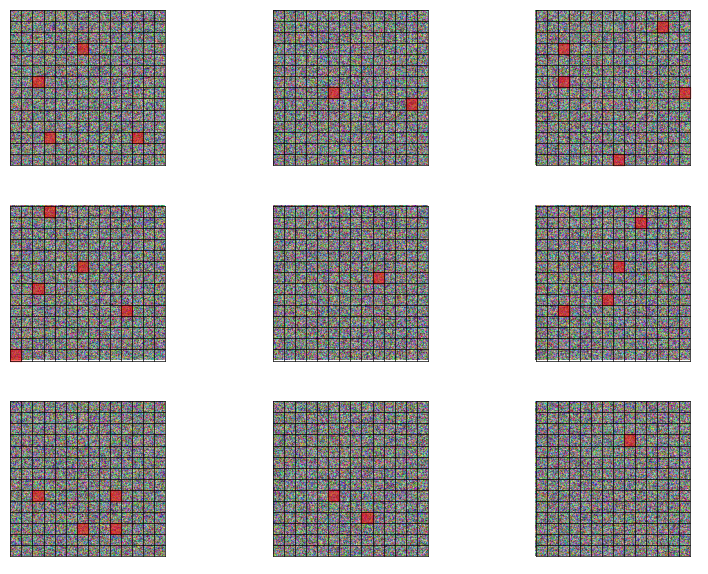

In [99]:
plot(image_np, result)